#guroby

In [ ]:
! pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 34.2 MB/s eta 0:00:00


In [ ]:
from gurobipy import Model, GRB, quicksum


n = 48
m = 3

D = [100] * n
MarketPrice = [
    [100] * m for _ in range(n)
]

P_max_H = [151, 152, 150]
P_max_L = [55, 61, 50]

Q_max_H = [179, 183, 167]
Q_max_L = [78, 93, 66]

Efficiency_H = [0.844, 0.831, 0.898]
Efficiency_L = [0.705, 0.656, 0.758]

Cg = 2533560
Cs = 844520
WaterCost = 10000

model = Model("Hydropower Optimization")

# Decision Variables
P = model.addVars(n, m, vtype=GRB.CONTINUOUS, name="P")  # Power generated
Q = model.addVars(n, m, vtype=GRB.CONTINUOUS, name="Q")  # Water flow
y = model.addVars(n, m, vtype=GRB.BINARY, name="y")      # ON/OFF state
y_H = model.addVars(n, m, vtype=GRB.BINARY, name="y_H")  # High state
y_L = model.addVars(n, m, vtype=GRB.BINARY, name="y_L")  # Low state
z = model.addVars(n, m, vtype=GRB.BINARY, name="z")      # Startup state

# Objective Function
model.setObjective(
    quicksum(
        P[i, j] * MarketPrice[i][j] - Cg * P[i, j] - Cs * z[i, j] - WaterCost * Q[i, j]
        for i in range(n) for j in range(m)
    ),
    GRB.MAXIMIZE
)

# Constraints

# State Exclusivity
model.addConstrs((y_H[i, j] + y_L[i, j] == y[i, j] for i in range(n) for j in range(m)), name="StateExclusivity")

# Power Capacity
model.addConstrs((P[i, j] <= P_max_H[j] * y_H[i, j] for i in range(n) for j in range(m)), name="PowerHigh")
model.addConstrs((P[i, j] <= P_max_L[j] * y_L[i, j] for i in range(n) for j in range(m)), name="PowerLow")
model.addConstrs((P[i, j] >= 0 for i in range(n) for j in range(m)), name="PowerNonNegative")

# Water Flow Limits
model.addConstrs((Q[i, j] <= Q_max_H[j] * y_H[i, j] for i in range(n) for j in range(m)), name="WaterHigh")
model.addConstrs((Q[i, j] <= Q_max_L[j] * y_L[i, j] for i in range(n) for j in range(m)), name="WaterLow")
model.addConstrs((Q[i, j] >= 0 for i in range(n) for j in range(m)), name="WaterNonNegative")

# Efficiency Relationships
model.addConstrs((P[i, j] == Efficiency_H[j] * Q[i, j] * y_H[i, j] for i in range(n) for j in range(m)), name="EfficiencyHigh")
model.addConstrs((P[i, j] == Efficiency_L[j] * Q[i, j] * y_L[i, j] for i in range(n) for j in range(m)), name="EfficiencyLow")

# Startup Constraints
model.addConstrs((z[i, j] >= y[i, j] - y[i-1, j] for i in range(1, n) for j in range(m)), name="StartupLowerBound")
model.addConstrs((z[i, j] <= y[i, j] for i in range(n) for j in range(m)), name="StartupUpperBound")
model.addConstrs((z[0, j] == y[0, j] for j in range(m)), name="StartupInitialization")

# Demand Satisfaction
model.addConstrs((quicksum(P[i, j] for j in range(m)) >= D[i] for i in range(n)), name="DemandSatisfaction")

# Optimize
model.optimize()

# Print Results
if model.status == GRB.OPTIMAL:
    print("Optimal Objective Value:", model.objVal)
    for i in range(n):
        for j in range(m):
            print(f"Interval {i+1}, Generator {j+1}:")
            print(f"  Power: {P[i, j].x:.2f}")
            print(f"  Water Flow: {Q[i, j].x:.2f}")
            print(f"  ON/OFF: {y[i, j].x:.0f}")
            print(f"  High State: {y_H[i, j].x:.0f}")
            print(f"  Low State: {y_L[i, j].x:.0f}")
            print(f"  Startup: {z[i, j].x:.0f}")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

#Pulp-CBC

In [1]:
! pip install pulp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.9 MB/s eta 0:00:00


In [2]:
import pulp

###Example Data
hour = 48  # number of intervals (hours of 2 days)
gen = 3   # number of hydro-generators

# Demand = 250 MW each hour (static)
D = [250] * hour

# Market prices (same for each generator in interval i)
raw_prices = [
    57, 56, 55, 54, 51, 51, 46, 47, 48, 48,
    49, 54, 53, 52, 56, 56, 62.5, 62.5, 62.5, 62.5,
    62.5, 62.5, 62.5, 62.5, 62.5, 62.5, 69, 89, 97, 155,
    280, 280, 280, 104, 96, 71, 61, 66, 84, 64,
    62, 70, 63, 63, 58, 63, 63, 57
]
MarketPrice = [[raw_prices[i]] * gen for i in range(hour)]

# Power capacity for High / Low states
P_max_H = [151, 152, 150]
P_max_L = [16,  61,  15]

# Water flow capacity for High / Low states
Q_max_H = [179, 183, 14]
Q_max_L = [25,  93,  31]

# Efficiencies for High / Low states
Efficiency_H = [0.844, 0.831, 0.58]
Efficiency_L = [0.1, 0.656, 0.35]

# Costs
Cg = 50            # generation, $/MWh
Cs = 250           # startup $
WaterCost = 25     # $/unit water
NoLoadCost = [25, 5, 0]  # $/interval per gen


###Model
model = pulp.LpProblem("Hydropower_Optimization", pulp.LpMaximize)

###Decision Variables
# Power by state and total
P_H = pulp.LpVariable.dicts("P_H", [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)
P_L = pulp.LpVariable.dicts("P_L", [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)
P   = pulp.LpVariable.dicts("P",   [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)

# Water by state and total
Q_H = pulp.LpVariable.dicts("Q_H", [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)
Q_L = pulp.LpVariable.dicts("Q_L", [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)
Q   = pulp.LpVariable.dicts("Q",   [(i, j) for i in range(hour) for j in range(gen)],
                            lowBound=0, cat=pulp.LpContinuous)

# state indicators
y   = pulp.LpVariable.dicts("y",   [(i, j) for i in range(hour) for j in range(gen)],
                            cat=pulp.LpBinary) #on/off state
y_H = pulp.LpVariable.dicts("y_H", [(i, j) for i in range(hour) for j in range(gen)],
                            cat=pulp.LpBinary) #high state on/off
y_L = pulp.LpVariable.dicts("y_L", [(i, j) for i in range(hour) for j in range(gen)],
                            cat=pulp.LpBinary) #low state on/off
z   = pulp.LpVariable.dicts("z",   [(i, j) for i in range(hour) for j in range(gen)],
                            cat=pulp.LpBinary) #startup


### Objective: revenue - costs (generation, startup, water, no-load)

obj_terms = []
for i in range(hour):
    for j in range(gen):
        revenue      = P[(i, j)] * MarketPrice[i][j]
        generation_c = Cg * P[(i, j)]
        water_c      = WaterCost * (Q_H[(i, j)] + Q_L[(i, j)])
        startup_c    = Cs * z[(i, j)]
        no_load_c    = NoLoadCost[j] * y[(i, j)]
        obj_terms.append(revenue - generation_c - water_c - startup_c - no_load_c)

model += pulp.lpSum(obj_terms), "Total_Profit"

### Constraints

# (a) State exclusivity
for i in range(hour):
    for j in range(gen):
        model += y_H[(i, j)] + y_L[(i, j)] == y[(i, j)], f"StateExcl_{i}_{j}"

# (b) Power capacity (by state via totals)
for i in range(hour):
    for j in range(gen):
        # Total power is sum of state powers
        model += P[(i, j)] == P_H[(i, j)] + P_L[(i, j)], f"P_sum_{i}_{j}"
        # Upper bounds activated only when that state is on
        model += P_H[(i, j)] <= P_max_H[j] * y_H[(i, j)], f"PcapH_{i}_{j}"
        model += P_L[(i, j)] <= P_max_L[j] * y_L[(i, j)], f"PcapL_{i}_{j}"

# (c) Water capacity (state-specific)
for i in range(hour):
    for j in range(gen):
        model += Q_H[(i, j)] <= Q_max_H[j] * y_H[(i, j)], f"QcapH_{i}_{j}"
        model += Q_L[(i, j)] <= Q_max_L[j] * y_L[(i, j)], f"QcapL_{i}_{j}"
        model += Q[(i, j)]   == Q_H[(i, j)] + Q_L[(i, j)], f"Q_sum_{i}_{j}"

# (d) Efficiency relations
for i in range(hour):
    for j in range(gen):
        model += P_H[(i, j)] <= Efficiency_H[j] * Q_H[(i, j)], f"PH_eff_{i}_{j}"
        model += P_L[(i, j)] <= Efficiency_L[j] * Q_L[(i, j)], f"PL_eff_{i}_{j}"

# (e) Startup constraints
for j in range(gen):
    model += z[(0, j)] == y[(0, j)], f"Startup_init_{j}"

for i in range(1, hour):
    for j in range(gen):
        model += z[(i, j)] >= y[(i, j)] - y[(i - 1, j)], f"Startup_lb_{i}_{j}"
        model += z[(i, j)] <= y[(i, j)],                 f"Startup_ub1_{i}_{j}"

# (f) Demand satisfaction
for i in range(hour):
    model += pulp.lpSum(P[(i, j)] for j in range(gen)) >= D[i], f"Demand_{i}"

# (g) Minimum power if ON
for i in range(hour):
    for j in range(gen):
        model += P[(i, j)] >= 10 * y[(i, j)], f"MinGen_{i}_{j}"


### Solve

solution_status = model.solve(
    pulp.PULP_CBC_CMD(
        msg=0,
        options=["sec 300", "ratio 0.01"]
    )
)

print("\nSolver Status:", pulp.LpStatus[solution_status])
print("Objective Value:", pulp.value(model.objective))


### Results
if pulp.LpStatus[solution_status] in ["Optimal", "Not Solved", "Stopped"]:
    for i in range(hour):
        for j in range(gen):
            p_val   = pulp.value(P[(i, j)])
            q_val   = pulp.value(Q[(i, j)])
            ph_val  = pulp.value(P_H[(i, j)])
            pl_val  = pulp.value(P_L[(i, j)])
            qh_val  = pulp.value(Q_H[(i, j)])
            ql_val  = pulp.value(Q_L[(i, j)])
            y_val   = pulp.value(y[(i, j)])
            y_h_val = pulp.value(y_H[(i, j)])
            y_l_val = pulp.value(y_L[(i, j)])
            z_val   = pulp.value(z[(i, j)])
            ##print(f"Interval {i:02d}, Gen {j}: "
                  ##f"P={p_val:7.2f}, Q={q_val:7.2f} (QH={qh_val:7.2f}, QL={ql_val:7.2f}), "
                 ## f"PH={ph_val:7.2f}, PL={pl_val:7.2f}, "
                  ##f"y={int(y_val)}, yH={int(y_h_val)}, yL={int(y_l_val)}, z={int(z_val)}")



Solver Status: Optimal
Objective Value: 23378.345500000087


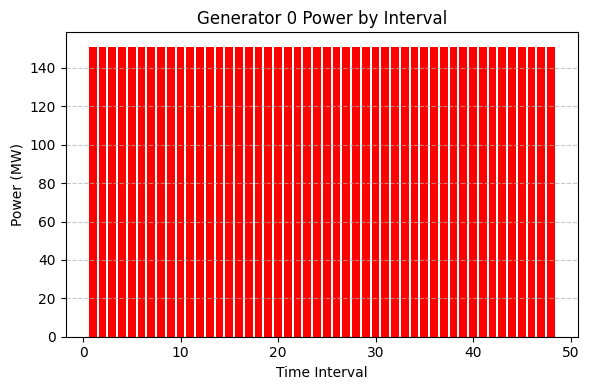

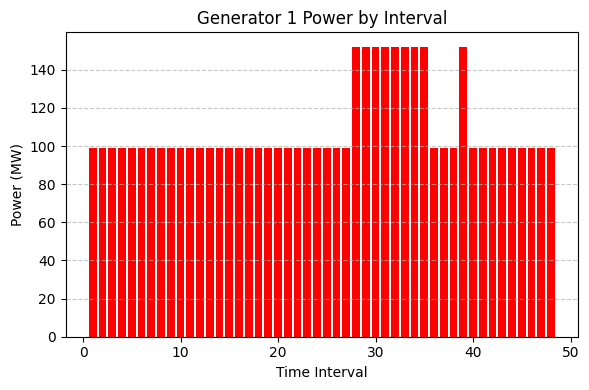

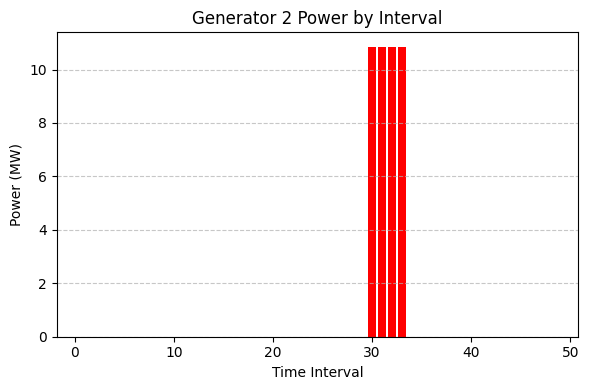

In [3]:
import matplotlib.pyplot as plt

for j in range(gen):
    # Gather power values for generator j across all intervals
    p_vals = [pulp.value(P[(i, j)]) for i in range(hour)]
    plt.figure(figsize=(6, 4))

    plt.bar(range(1, hour+1), p_vals, color='red')

    plt.title(f'Generator {j} Power by Interval')
    plt.xlabel('Time Interval')
    plt.ylabel('Power (MW)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
